In [24]:
from datascience import *
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

````markdown
Data from Social Security Administration is separated into many .txt files.  We need to write them to a single .csv file.
````

In [16]:
write_csv = open('../data/data1910-2010.csv', 'w')
SA_writer = csv.writer( write_csv, delimiter = ',', quotechar = '', quoting = csv.QUOTE_NONE)

SA_writer.writerow(['year', 'first_name', 'gender', 'count'])
for year in range(1910, 2020, 10):
    f         = open('../data/yob'+str(year)+'.txt', 'r')
    read_csv  = csv.reader(f, delimiter = ',')

    for line in read_csv:
        if line[0].isspace() == False:
            SA_writer.writerow([year, str(line[0]), str(line[1]), int(line[2])])

    f.close()

````markdown
Next we create a table out of the joined data and then split it into separate tables for men and women.  Plotted first twenty names of initial totals.
````

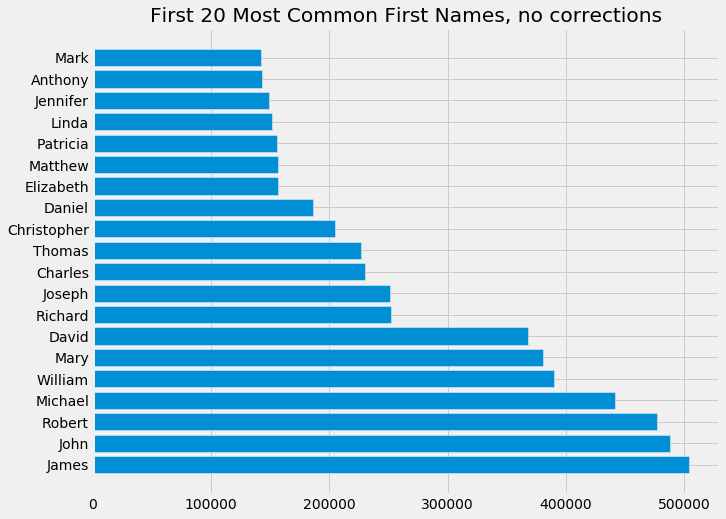

In [32]:
first_names = Table.read_table('../data/data1910-2010.csv')

male_first   = first_names.where('gender', 'M')
female_first = first_names.where('gender', 'F')

raw_total     = first_names.select(['first_name', 'count']).group('first_name', collect = sum)
raw_sorted    = raw_total.sort('count sum', descending = True)
first_20names = raw_sorted.take[:20]

plt.figure(1, figsize = (10,8))
plt.barh(first_20names.column('first_name'), first_20names.column('count sum'))
plt.title('First 20 Most Common First Names, no corrections')

plt.show()

````markdown
Different names are more popular at different times.  To try to account for this, we use a table that shows how many people born in a particular decade are still alive (in 2013).  For each decade, we turn the number of people alive into a percentage and apply percentage alive to the sum of every name in that decade.

First, finding percentage of people from each decade still alive.
````

In [33]:
#people still alive in 2013
alive = Table.read_table('../data/aging-curve.csv')

#split them into male and female tables
male_alive   = alive.select(['Decade', 'Age', 'Male'])
female_alive = alive.select(['Decade', 'Age', 'Female'])

# takes a table and returns total names in each year (use this as total people born that year)
def sum_by_year(table):
    total = []
    for year in range(1910, 2020, 10):
        year_total = 0
        year_total = table.where('year', year).column('count').sum()
        total.append(year_total)
    return total

male_total_by_year   = sum_by_year(male_first)
female_total_by_year = sum_by_year(female_first)

#exclude 1900 row
male_alive   = male_alive.exclude(0)
female_alive = female_alive.exclude(0)

#add decade total column
male_alive   = male_alive.with_column('total', male_total_by_year)
female_alive = female_alive.with_column('total', female_total_by_year)

#take 'number still alive' column and divide by 'total for year' column
def find_percent(table, column):
    count   = table.column(column)
    total   = table.column('total')
    percent = count/total
    return table.with_column('percent_alive', percent)

male_percent   = find_percent(male_alive, 'Male')
female_percent = find_percent(female_alive, 'Female')

In [6]:
female_percent

Decade,Age,Female,total,percent_alive
1910,103,318,396502,0.000802014
1920,93,11403,1198290,0.00951606
1930,83,44336,1125885,0.0393788
1940,73,70955,1143393,0.0620565
1950,63,86389,1713151,0.050427
1960,53,92468,2022018,0.0457306
1970,43,95619,1748175,0.0546965
1980,33,97619,1660147,0.0588014
1990,23,98570,1898046,0.0519324
2000,13,99178,1815110,0.0546402


In [7]:
alive

Decade,Age,Male,Female,Male.1,Female.1
1900,113,0,0,0,0
1910,103,45,318,0.00045,0.00318
1920,93,4154,11403,0.04154,0.11403
1930,83,28836,44336,0.28836,0.44336
1940,73,58728,70955,0.58728,0.70955
1950,63,78170,86389,0.7817,0.86389
1960,53,87064,92468,0.87064,0.92468
1970,43,92710,95619,0.9271,0.95619
1980,33,96010,97619,0.9601,0.97619
1990,23,97802,98570,0.97802,0.9857


````markdown
The percentages that we get don't look right; 5% of people born in 2010 are still alive?

We decided to interpret the last two columns in the 'alive' table as the percent of people born that decade who are still alive.
````

In [34]:
#2nd way to correct for deaths

#people still alive in 2013
alive = Table.read_table('../data/aging-curve.csv')
alive = alive.exclude(0) #dropping 1900 row

#take the 'Male.1' and 'Female.1' columns (hopefully they mean percentage of people still alive from that year)
correction_m = alive.column('Male.1')
correction_f = alive.column('Female.1')

#function that applies the correction values to a table
def age_correct(table, value):
    corrected_counts = []
    index = 0
    for year in range(1910, 2020, 10):
        counts = table.where('year', year).column('count')
        counts = np.round(counts * value[index])
        index  += 1
        corrected_counts.extend(list(counts))
    return corrected_counts

corrected_m  = age_correct(male_first, correction_m)
male_first   = male_first.with_column('age_corrected', corrected_m)
corrected_f  = age_correct(female_first, correction_f)
female_first = female_first.with_column('age_corrected', corrected_f)

In [24]:
female_first

year,first_name,gender,count,age_corrected
1910,Mary,F,22848,73
1910,Helen,F,10479,33
1910,Margaret,F,8226,26
1910,Dorothy,F,7318,23
1910,Ruth,F,7212,23
1910,Anna,F,6436,20
1910,Elizabeth,F,5800,18
1910,Mildred,F,5692,18
1910,Marie,F,4790,15
1910,Alice,F,4671,15


In [38]:
male_total    = male_first.select(['first_name', 'age_corrected']).group('first_name', collect = sum)
female_total  = female_first.select(['first_name', 'age_corrected']).group('first_name', collect = sum)

male_sorted   = male_total.sort('age_corrected sum', descending = True)
female_sorted = female_total.sort('age_corrected sum', descending = True)

joined_table  = male_sorted.append(female_sorted)
joined_table  = joined_table.sort('age_corrected sum', descending = True)
joined_first20 = joined_table.take[0:20]

first_name,age_corrected sum
Michael,391007
James,346796
John,325923
Robert,319500
David,306566
William,254855
Mary,227750
Christopher,193440
Joseph,184407
Richard,176680


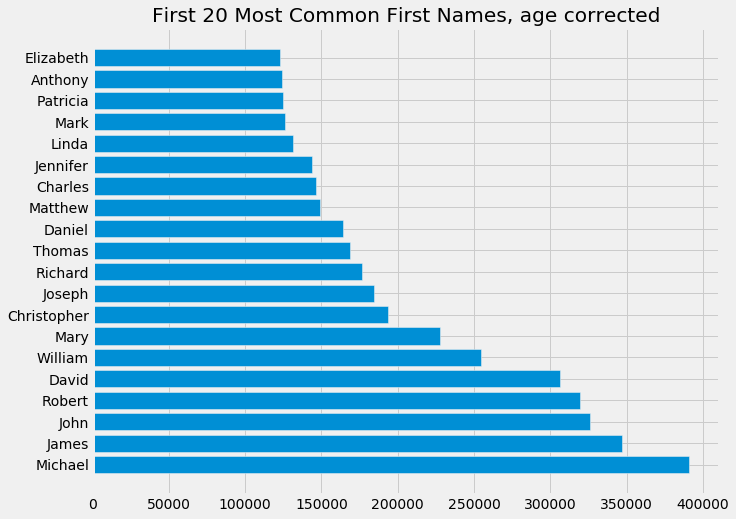

In [39]:
plt.figure(1, figsize = (10,8))
plt.barh(joined_first20.column('first_name'), joined_first20.column('age_corrected sum'))
plt.title('First 20 Most Common First Names, age corrected')

plt.show()

````markdown
The ethnicity adjustment table only has certain (first + last) name combinations.  Drop rows where the first name is not in the adjustment table.
````

In [6]:
def drop_names(entry):
    to_keep = ['John', 'Michael', 'James', 'Robert', 'David', 'Mary', 'William',
               'Richard', 'Thomas', 'Jennifer', 'Patricia', 'Joseph', 'Linda',
               'Maria', 'Charles', 'Barbara', 'Mark', 'Daniel', 'Susan', 'Elizabeth']

    for name in to_keep:
        if entry == name:
            return True
    return False

short_Mfirst = male_first.where('first_name', drop_names)
short_Ffirst = female_first.where('first_name', drop_names)

short_Mfirst.show(20)